<a href="https://colab.research.google.com/github/OfficialAnujMore/Regional-Sales-Data-Analysis/blob/main/Regional_Sales_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement

2014-2018 sales data to identify key revenue and profits



In [33]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sheets = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name=None)

In [35]:
# Assign dataframes to each sheet
df_sales = sheets['Sales Orders']
df_customers = sheets['Customers']
df_products = sheets['Products']
df_regions = sheets['Regions']
df_state_reg = sheets['State Regions']
df_budgets = sheets['2017 Budgets']

In [36]:
df_sales.head()

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,Line Total,Total Unit Cost
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,14994.6,1824.343
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,25868.7,1269.918
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,5869.2,684.740
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,16368.1,1028.852
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,18331.2,1260.270


In [37]:
df_customers.head()

,Customer Index,Customer Names
0,1,Geiss Company
1,2,Jaxbean Group
2,3,Ascend Ltd
3,4,Eire Corp
4,5,Blogtags Ltd


In [38]:
df_products.head()

,Index,Product Name
0,1,Product 1
1,2,Product 2
2,3,Product 3
3,4,Product 4
4,5,Product 5


In [39]:
df_regions.head()

,id,name,county,state_code,state,type,latitude,longitude,area_code,population,households,median_income,land_area,water_area,time_zone
0,1,Auburn,Lee County,AL,Alabama,City,32.60986,-85.48078,334,62059,21767,38342,152375113,2646161,America/Chicago
1,2,Birmingham,Shelby County/Jefferson County,AL,Alabama,City,33.52744,-86.79905,205,212461,89972,31061,378353942,6591013,America/Chicago
2,3,Decatur,Limestone County/Morgan County,AL,Alabama,City,34.57332,-86.99214,256,55437,22294,41496,141006257,17594716,America/Chicago
3,4,Dothan,Dale County/Houston County/Henry County,AL,Alabama,City,31.23370,-85.40682,334,68567,25913,42426,232166237,835468,America/Chicago
4,5,Hoover,Shelby County/Jefferson County,AL,Alabama,City,33.37695,-86.80558,205,84848,32789,77146,122016784,2553332,America/Chicago


In [40]:
df_state_reg.head()

,State Code,State,Region
0,AL,Alabama,South
1,AR,Arkansas,South
2,AZ,Arizona,West
3,CA,California,West
4,CO,Colorado,West


In [41]:
df_budgets.head()

,Product Name,2017 Budgets
0,Product 1,3016489.209
1,Product 2,3050087.565
2,Product 3,2642352.432
3,Product 4,2885560.824
4,Product 5,3925424.542


# Data Cleaning and Wrangling

In [42]:
df = df_sales.merge(
    df_customers,
    how='left',
    left_on='Customer Name Index',
    right_on='Customer Index'
  )

In [43]:
# New data frame created merging sales and customer data

df.head()

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,Line Total,Total Unit Cost,Customer Index,Customer Names
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,14994.6,1824.343,126,Rhynoodle Ltd
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,25868.7,1269.918,96,Thoughtmix Ltd
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,5869.2,684.740,8,Amerisourc Corp
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,16368.1,1028.852,42,Colgate-Pa Group
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,18331.2,1260.270,73,Deseret Group


In [44]:
# Merge with products
df = df.merge(
    df_products,
    how='left',
    left_on='Product Description Index',
    right_on='Index'
  )

In [45]:
# Merge with regions
df = df.merge(
    df_regions,
    how='left',
    left_on='Delivery Region Index',
    right_on='id'
  )

In [46]:
df.head()

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,...,type,latitude,longitude,area_code,population,households,median_income,land_area,water_area,time_zone
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,...,City,32.08354,-81.09983,912,145674,52798,36466,268318796,13908113,America/New York
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,...,City,39.61366,-86.10665,317,55586,20975,54176,72276415,1883,America/Indiana/Indianapolis
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,...,City,37.66243,-121.87468,925,79510,26020,124759,62489257,386195,America/Los Angeles
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,...,City,39.16533,-86.52639,812,84067,30232,30019,60221613,475857,America/Indiana/Indianapolis
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,...,Town,41.77524,-72.52443,959,58007,24141,63158,70972793,720300,America/New York


In [47]:
# Merge with State Regions
df = df.merge(
    df_state_reg[["State Code", "Region"]],
    how='left',
    left_on='state_code',
    right_on='State Code'
  )

In [48]:
# Merge with the budgets
df = df.merge(
    df_budgets,
    how='left',
    on='Product Name'
  )

In [49]:
df.head(5)

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,...,area_code,population,households,median_income,land_area,water_area,time_zone,State Code,Region,2017 Budgets
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,...,912,145674,52798,36466,268318796,13908113,America/New York,GA,South,964940.231
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,...,317,55586,20975,54176,72276415,1883,America/Indiana/Indianapolis,IN,Midwest,2067108.120
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,...,925,79510,26020,124759,62489257,386195,America/Los Angeles,CA,West,5685138.270
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,...,812,84067,30232,30019,60221613,475857,America/Indiana/Indianapolis,IN,Midwest,889737.555
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,...,959,58007,24141,63158,70972793,720300,America/New York,CT,Northeast,1085037.329


In [50]:
# Customer Index
# Index
# id
# State Code

# Clean up duplicate columns after merging data

cols_to_drop = ['Customer Index', 'Index', 'id', 'State Code']
df = df.drop(columns=cols_to_drop, errors='ignore')

In [51]:
df.head(5)

,OrderNumber,OrderDate,Customer Name Index,Channel,Currency Code,Warehouse Code,Delivery Region Index,Product Description Index,Order Quantity,Unit Price,...,longitude,area_code,population,households,median_income,land_area,water_area,time_zone,Region,2017 Budgets
0,SO - 000225,2014-01-01,126,Wholesale,USD,AXW291,364,27,6,2499.1,...,-81.09983,912,145674,52798,36466,268318796,13908113,America/New York,South,964940.231
1,SO - 0003378,2014-01-01,96,Distributor,USD,AXW291,488,20,11,2351.7,...,-86.10665,317,55586,20975,54176,72276415,1883,America/Indiana/Indianapolis,Midwest,2067108.120
2,SO - 0005126,2014-01-01,8,Wholesale,USD,AXW291,155,26,6,978.2,...,-121.87468,925,79510,26020,124759,62489257,386195,America/Los Angeles,West,5685138.270
3,SO - 0005614,2014-01-01,42,Export,USD,AXW291,473,7,7,2338.3,...,-86.52639,812,84067,30232,30019,60221613,475857,America/Indiana/Indianapolis,Midwest,889737.555
4,SO - 0005781,2014-01-01,73,Wholesale,USD,AXW291,256,8,8,2291.4,...,-72.52443,959,58007,24141,63158,70972793,720300,America/New York,Northeast,1085037.329


In [52]:
# Converting all columns to lower case for consistency and easier access

df.columns = df.columns.str.lower()
df.columns.values

array(['ordernumber', 'orderdate', 'customer name index', 'channel',
       'currency code', 'warehouse code', 'delivery region index',
       'product description index', 'order quantity', 'unit price',
       'line total', 'total unit cost', 'customer names', 'product name',
       'name', 'county', 'state_code', 'state', 'type', 'latitude',
       'longitude', 'area_code', 'population', 'households',
       'median_income', 'land_area', 'water_area', 'time_zone', 'region',
       '2017 budgets'], dtype=object)

In [53]:
# Keep the important columns and delete the once we dont need
cols_to_keep = [
    'ordernumber',
    'orderdate',
    'customer names',
    'channel',
    'product name',
    'order quantity',
    'unit price',
    'line total',
    'total unit cost',
    'state_code',
    'county',
    'state',
    'region',
    'latitude',
    'longitude',
    '2017 budgets'
]


In [54]:
df = df[cols_to_keep]
df.head(5)

,ordernumber,orderdate,customer names,channel,product name,order quantity,unit price,line total,total unit cost,state_code,county,state,region,latitude,longitude,2017 budgets
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,Chatham County,Georgia,South,32.08354,-81.09983,964940.231
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,Johnson County,Indiana,Midwest,39.61366,-86.10665,2067108.120
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,Alameda County,California,West,37.66243,-121.87468,5685138.270
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,Monroe County,Indiana,Midwest,39.16533,-86.52639,889737.555
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,Hartford County,Connecticut,Northeast,41.77524,-72.52443,1085037.329


In [55]:
# Rename the columns
df = df.rename(columns={
    'ordernumber': 'order_number',
    'orderdate': 'order_date',
    'customer names': 'customer_name',
    'product name':'product_name',
    'order quantity': 'quantity',
    'unit price': 'unit_price',
    'line total': 'revenue',
    'total unit cost': 'cost',
    'state_code': 'state',
    'state':'state_name',
    'region':'us_region',
    'latitude': 'lat',
    'longitude': 'lon',
    '2017 budgets': 'budget'
})
df.head(5)

,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,county,state_name,us_region,lat,lon,budget
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,Chatham County,Georgia,South,32.08354,-81.09983,964940.231
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,Johnson County,Indiana,Midwest,39.61366,-86.10665,2067108.120
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,Alameda County,California,West,37.66243,-121.87468,5685138.270
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,Monroe County,Indiana,Midwest,39.16533,-86.52639,889737.555
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,Hartford County,Connecticut,Northeast,41.77524,-72.52443,1085037.329


In [56]:
# Blank out budges for non 2017 orders

df.loc[df['order_date'].dt.year!= 2017,'budget'] = pd.NA

# line total is revenue
df[['order_date','product_name', 'revenue', 'budget' ]].head(5)

,order_date,product_name,revenue,budget
0,2014-01-01,Product 27,14994.6,NaN
1,2014-01-01,Product 20,25868.7,NaN
2,2014-01-01,Product 26,5869.2,NaN
3,2014-01-01,Product 7,16368.1,NaN
4,2014-01-01,Product 8,18331.2,NaN


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_number   64104 non-null  object        
 1   order_date     64104 non-null  datetime64[ns]
 2   customer_name  64104 non-null  object        
 3   channel        64104 non-null  object        
 4   product_name   64104 non-null  object        
 5   quantity       64104 non-null  int64         
 6   unit_price     64104 non-null  float64       
 7   revenue        64104 non-null  float64       
 8   cost           64104 non-null  float64       
 9   state          64104 non-null  object        
 10  county         64104 non-null  object        
 11  state_name     64104 non-null  object        
 12  us_region      64104 non-null  object        
 13  lat            64104 non-null  float64       
 14  lon            64104 non-null  float64       
 15  budget         1526

In [58]:
# Filter the dateset to include only records for year 2017
df_2017 = df[df['order_date'].dt.year == 2017]
df_2017.isnull().sum()

,0
order_number,0
order_date,0
customer_name,0
channel,0
product_name,0
quantity,0
unit_price,0
revenue,0
cost,0
state,0


# Feature Engineering

In [59]:
df_2017.head(5)

,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,county,state_name,us_region,lat,lon,budget
46363,SO - 0002544,2017-01-01,NCS Group,Wholesale,Product 30,6,1239.5,7437.0,1028.785,NJ,Hudson County,New Jersey,Northeast,40.77955,-74.02375,1011609.684
46364,SO - 0006431,2017-01-01,Epic Group,Wholesale,Product 13,5,1829.1,9145.5,1207.206,CO,Mesa County,Colorado,West,39.06387,-108.55065,3720639.645
46365,SO - 0007491,2017-01-01,State Ltd,Wholesale,Product 15,9,2412.0,21708.0,1664.280,CA,Los Angeles County,California,West,33.96168,-118.35313,3299478.315
46366,SO - 0008741,2017-01-01,Fivebridge Ltd,Wholesale,Product 8,8,904.5,7236.0,750.735,IA,Dubuque County,Iowa,Midwest,42.50056,-90.66457,1085037.329
46367,SO - 0009295,2017-01-01,Tagfeed Ltd,Wholesale,Product 2,12,1112.2,13346.4,811.906,FL,Hernando County,Florida,South,28.47689,-82.52546,3050087.565


In [60]:
df['total_cost'] = df['quantity'] * df['cost']

In [61]:
df['profit'] = df['revenue'] - df['total_cost']
df['profit_margin_pct'] = df['profit']/df['revenue'] * 100

In [62]:
df.head(5)

,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,county,state_name,us_region,lat,lon,budget,total_cost,profit,profit_margin_pct
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,Chatham County,Georgia,South,32.08354,-81.09983,NaN,10946.058,4048.542,27.0
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,Johnson County,Indiana,Midwest,39.61366,-86.10665,NaN,13969.098,11899.602,46.0
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,Alameda County,California,West,37.66243,-121.87468,NaN,4108.440,1760.760,30.0
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,Monroe County,Indiana,Midwest,39.16533,-86.52639,NaN,7201.964,9166.136,56.0
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,Hartford County,Connecticut,Northeast,41.77524,-72.52443,NaN,10082.160,8249.040,45.0


# EDA


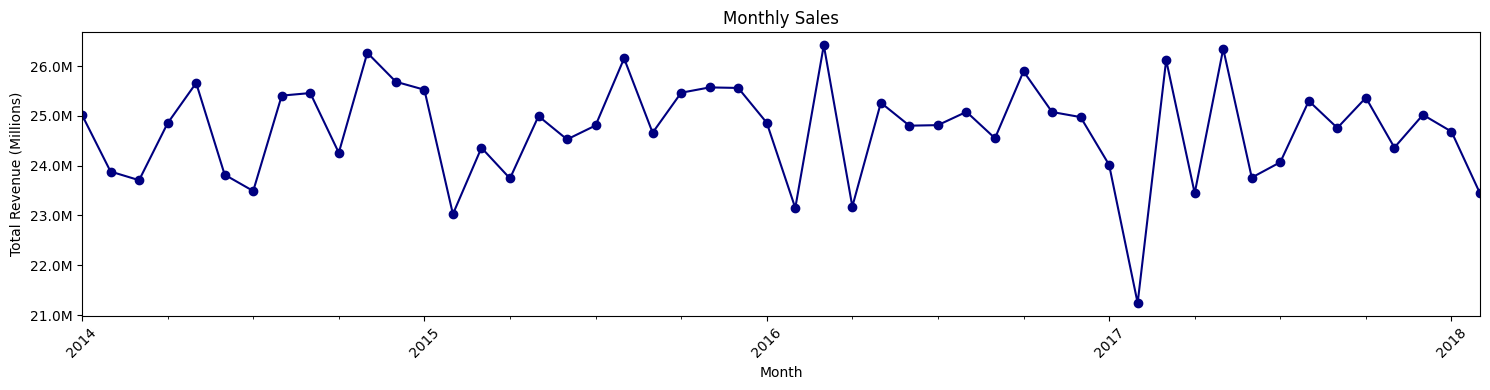

In [63]:
df['order_month'] = df['order_date'].dt.to_period('M')
monthly_sales = df.groupby('order_month')['revenue'].sum()
plt.figure(figsize=(15,4))
monthly_sales.plot(marker='o', color='navy')

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Revenue (Millions)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [64]:
df['order_month_name'] = df['order_date'].dt.month_name()
df['order_month_num'] = df['order_date'].dt.month

df

,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,...,us_region,lat,lon,budget,total_cost,profit,profit_margin_pct,order_month,order_month_name,order_month_num
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,...,South,32.08354,-81.09983,NaN,10946.058,4048.542,27.0,2014-01,January,1
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,...,Midwest,39.61366,-86.10665,NaN,13969.098,11899.602,46.0,2014-01,January,1
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,...,West,37.66243,-121.87468,NaN,4108.440,1760.760,30.0,2014-01,January,1
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,...,Midwest,39.16533,-86.52639,NaN,7201.964,9166.136,56.0,2014-01,January,1
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,...,Northeast,41.77524,-72.52443,NaN,10082.160,8249.040,45.0,2014-01,January,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64099,SO - 0007573,2018-02-28,Dazzlesphe Corp,Wholesale,Product 26,12,1815.7,21788.4,980.478,PA,...,Northeast,40.15511,-74.82877,NaN,11765.736,10022.664,46.0,2018-02,February,2
64100,SO - 0007706,2018-02-28,Yombu Corp,Export,Product 21,6,864.3,5185.8,579.081,IL,...,Midwest,42.11030,-88.03424,NaN,3474.486,1711.314,33.0,2018-02,February,2
64101,SO - 0007718,2018-02-28,Bath Group,Distributor,Product 13,11,3953.0,43483.0,2648.510,FL,...,South,26.24453,-80.20644,NaN,29133.610,14349.390,33.0,2018-02,February,2
64102,SO - 0008084,2018-02-28,Linklinks Ltd,Distributor,Product 20,7,3959.7,27717.9,2930.178,NY,...,Northeast,42.91002,-78.74182,NaN,20511.246,7206.654,26.0,2018-02,February,2


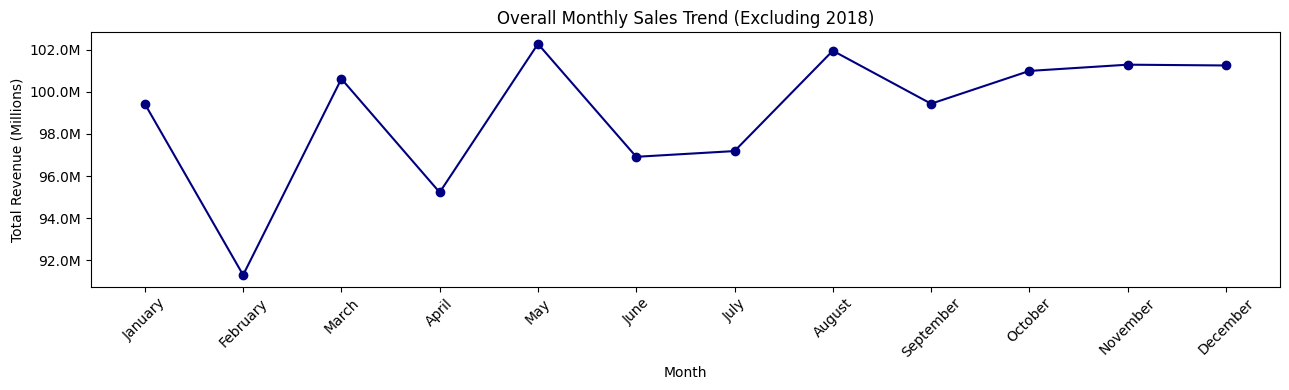

In [65]:

# 1. Filter out any 2018 orders
df_ = df[df['order_date'].dt.year != 2018]   # exclude any partial-year data (i.e., January and February of 2018) so that the monthly totals aren’t skewed by an incomplete year.
                                            #I create df_ so I don’t alter the original df, preserving it intact for other analyses while filtering just for this chart.


# 2. Group by month number and month name, sum revenue, then sort by month number
monthly_sales = (
    df_
    .groupby(['order_month_num', 'order_month_name'])['revenue']
    .sum()
    .sort_index()
)

# 3. Plot setup
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(13, 4))
plt.plot(
    monthly_sales.index.get_level_values(1),  # X-axis: month names
    monthly_sales.values,                     # Y-axis: total revenue
    marker='o',                                # circle markers
    color='navy'                               # line color
)

# 4. Scale y-axis values to millions for readability
formatter = FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# 5. Add title and axis labels
plt.title('Overall Monthly Sales Trend (Excluding 2018)')
plt.xlabel('Month')
plt.ylabel('Total Revenue (Millions)')

# 6. Rotate x-axis labels for readability
plt.xticks(rotation=45)

# 7. Adjust layout to prevent clipping
plt.tight_layout()

# 8. Display the plot
plt.show()

/tmp/ipython-input-66-1186821662.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


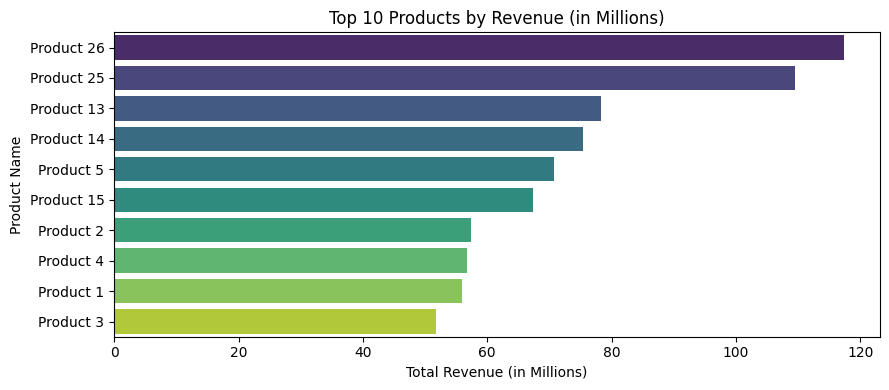

In [66]:
# Calculate total revenue for each product and convert values to millions
top_prod = df.groupby('product_name')['revenue'].sum() / 1_000_000

# Select the top 10 products by revenue
top_prod = top_prod.nlargest(10)

# Set the figure size for clarity
plt.figure(figsize=(9, 4))

# Plot a horizontal bar chart: x-axis as revenue in millions, y-axis as product names
sns.barplot(
    x=top_prod.values,    # X-axis: revenue values in millions
    y=top_prod.index,     # Y-axis: product names
    palette='viridis'     # Color palette for bars
)

# Add title and axis labels
plt.title('Top 10 Products by Revenue (in Millions)')  # Main title
plt.xlabel('Total Revenue (in Millions)')              # X-axis label
plt.ylabel('Product Name')                             # Y-axis label

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

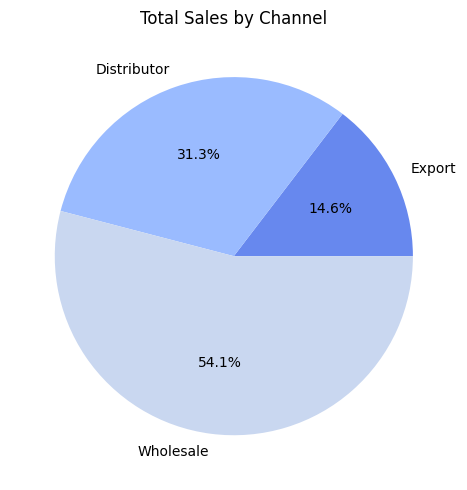

In [67]:
# Sales by channel

chan_sales =df.groupby('channel')['revenue'].sum().sort_values(ascending=True)

plt.figure(figsize=(5,5))
plt.pie(
    chan_sales.values,
    labels=chan_sales.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('coolwarm')
)
plt.title('Total Sales by Channel')
plt.tight_layout()
plt.show()

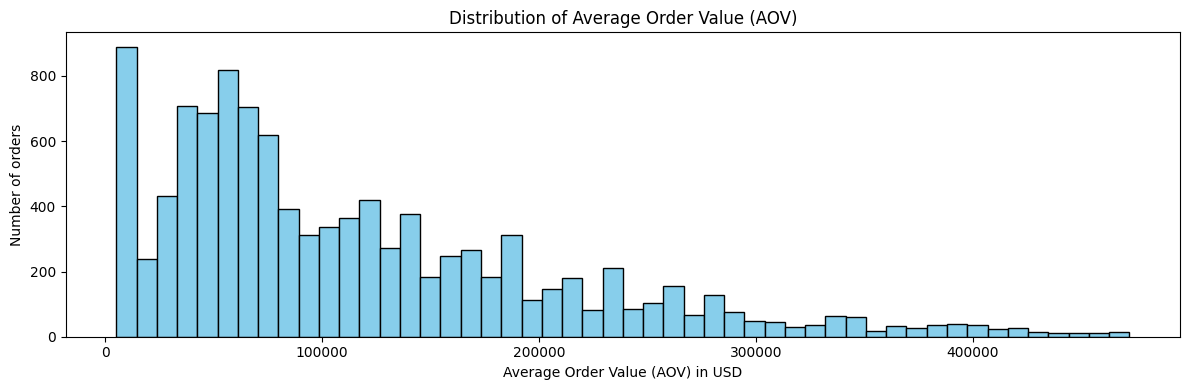

In [68]:
## Average order value (AOV) Distribution

aov=df.groupby('order_number')['revenue'].sum()
plt.figure(figsize=(12,4))
plt.hist(
    aov,
    bins=50,
    color='skyblue',
    edgecolor='black'
)

plt.title('Distribution of Average Order Value (AOV)')
plt.xlabel('Average Order Value (AOV) in USD')
plt.ylabel('Number of orders')
plt.tight_layout()
plt.show()


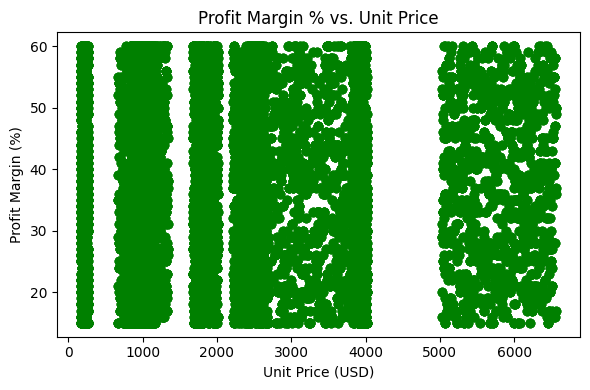

In [69]:

# Calculate profit margin percentage for each record
df['profit_margin_pct'] = (df['profit'] / df['revenue']) * 100

# Set the figure size for clarity
plt.figure(figsize=(6,4))

# Plot unit price vs. profit margin percentage
plt.scatter(
    df['unit_price'],            # X-axis: unit price in USD
    df['profit_margin_pct'],     # Y-axis: profit margin percentage
    alpha=0.6,                   # Transparency level for overlapping points
    color='green'                # Point color
)

# Add title and axis labels
plt.title('Profit Margin % vs. Unit Price')  # Chart title
plt.xlabel('Unit Price (USD)')                # X-axis label
plt.ylabel('Profit Margin (%)')               # Y-axis label

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

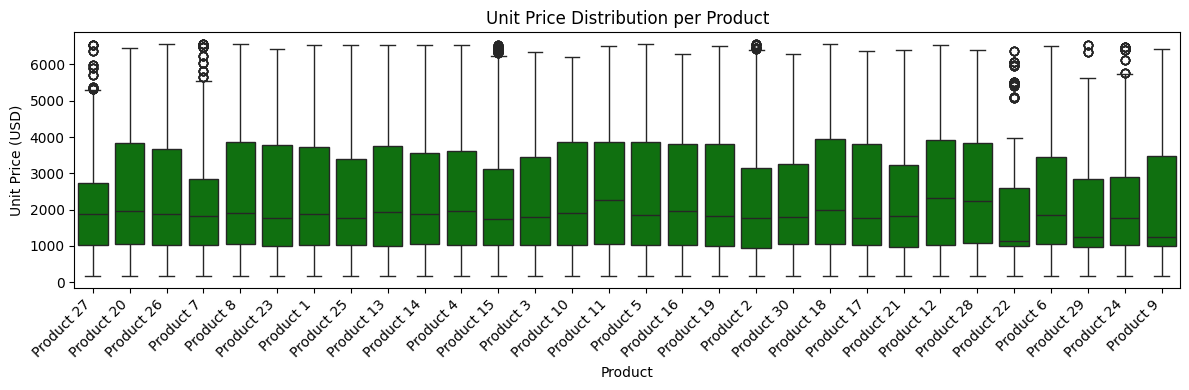

In [70]:
# Set figure size for clarity
plt.figure(figsize=(12,4))

# Create a boxplot of unit_price by product_name
sns.boxplot(
    data=df,
    x='product_name',   # X-axis: product categories
    y='unit_price',      # Y-axis: unit price values
    color='g'            # Box color
)

# Add title and axis labels
plt.title('Unit Price Distribution per Product')  # Chart title
plt.xlabel('Product')                              # X-axis label
plt.ylabel('Unit Price (USD)')                     # Y-axis label

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipython-input-71-1757589281.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


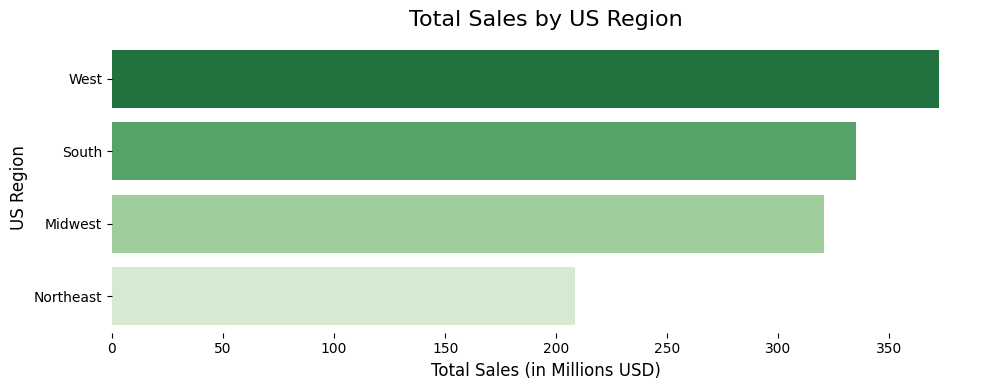

In [71]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate total sales by region (in millions)
region_sales = (
    df
    .groupby('us_region')['revenue']
    .sum()
    .sort_values(ascending=False)  # so bars go top→bottom
    / 1e6                         # convert to millions
)

# 2. Plot
plt.figure(figsize=(10, 4))
sns.barplot(
    x=region_sales.values,
    y=region_sales.index,
    palette='Greens_r'          # dark→light green
)

# 3. Formatting
plt.title('Total Sales by US Region', fontsize=16, pad=12)
plt.xlabel('Total Sales (in Millions USD)', fontsize=12)
plt.ylabel('US Region', fontsize=12)
plt.xticks(rotation=0)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [72]:

import plotly.express as px

# 1. Aggregate revenue by state (in millions)
state_sales = (
    df
    .groupby('state')['revenue']
    .sum()
    .reset_index()
)
state_sales['revenue_m'] = state_sales['revenue'] / 1e6  # convert to millions

# 2. Plotly choropleth
fig = px.choropleth(
    state_sales,
    locations='state',            # column with state codes
    locationmode='USA-states',    # tells Plotly these are US states
    color='revenue_m',
    scope='usa',
    labels={'revenue_m':'Total Sales (M USD)'},
    color_continuous_scale='Blues',
    hover_data={'revenue_m':':.2f'}  # show 2 decimals
)

# 3. Layout tuning
fig.update_layout(
    title_text='Total Sales by State',
    margin=dict(l=0, r=0, t=40, b=0),
    coloraxis_colorbar=dict(
        title='Sales (M USD)',
        ticksuffix='M'
    )
)

fig.show()

/tmp/ipython-input-73-1452768722.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-73-1452768722.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




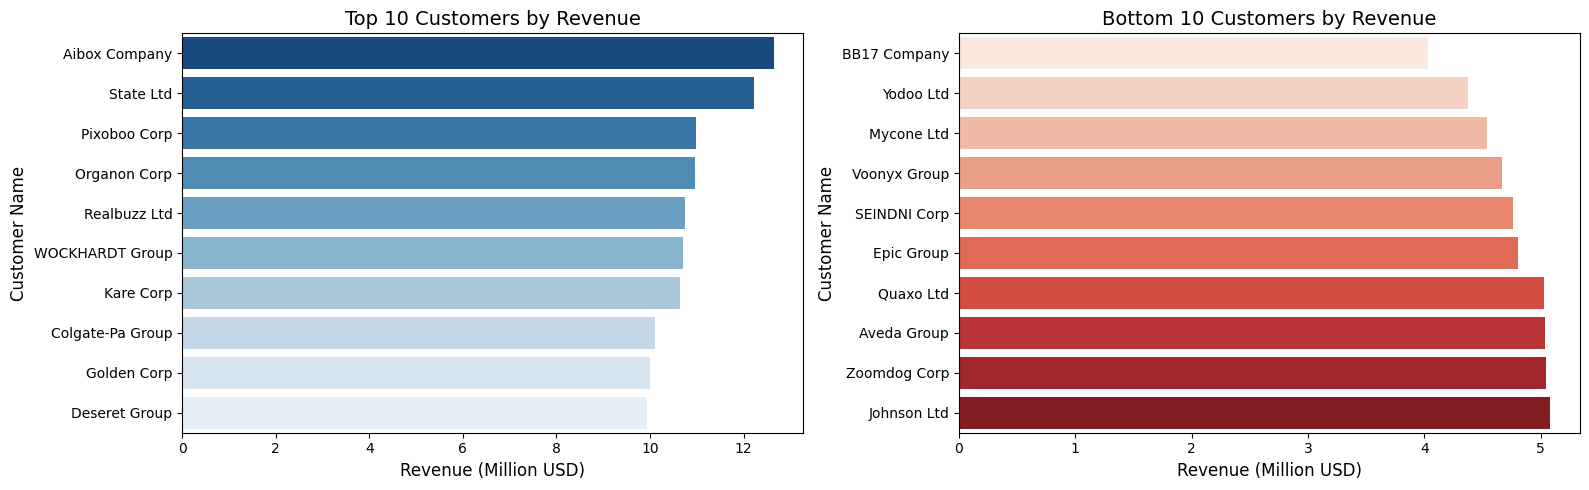

In [73]:
# 🔝 Calculate total revenue per customer and select top 10
top_rev = (
    df.groupby('customer_name')['revenue']
      .sum()                        # Sum revenue for each customer
      .sort_values(ascending=False) # Sort from highest to lowest
      .head(10)                     # Keep top 10 customers
)

# 🔻 Calculate total revenue per customer and select bottom 10
bottom_rev = (
    df.groupby('customer_name')['revenue']
      .sum()                        # Sum revenue for each customer
      .sort_values(ascending=True)  # Sort from lowest to highest
      .head(10)                     # Keep bottom 10 customers
)

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Top 10 customers by revenue (converted to millions)
sns.barplot(
    x=top_rev.values / 1e6,    # X-axis: revenue in millions
    y=top_rev.index,           # Y-axis: customer names
    palette='Blues_r',         # Color palette (reversed blues)
    ax=axes[0]                 # Draw on the left subplot
)
axes[0].set_title('Top 10 Customers by Revenue', fontsize=14)         # Title
axes[0].set_xlabel('Revenue (Million USD)', fontsize=12)              # X-axis label
axes[0].set_ylabel('Customer Name', fontsize=12)                      # Y-axis label

# Plot 2: Bottom 10 customers by revenue (converted to millions)
sns.barplot(
    x=bottom_rev.values / 1e6, # X-axis: revenue in millions
    y=bottom_rev.index,        # Y-axis: customer names
    palette='Reds',            # Color palette (reds)
    ax=axes[1]                 # Draw on the right subplot
)
axes[1].set_title('Bottom 10 Customers by Revenue', fontsize=14)      # Title
axes[1].set_xlabel('Revenue (Million USD)', fontsize=12)              # X-axis label
axes[1].set_ylabel('Customer Name', fontsize=12)                      # Y-axis label

# Adjust layout to prevent overlap and display both charts
plt.tight_layout()
plt.show()

/tmp/ipython-input-74-15237516.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




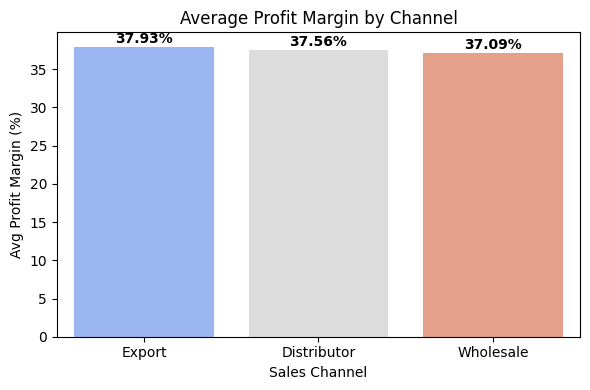

In [74]:
# 1️⃣ Compute average profit margin percentage for each channel
channel_margin = (
    df.groupby('channel')['profit_margin_pct']  # Group by sales channel
      .mean()                                  # Calculate mean profit margin %
      .sort_values(ascending=False)            # Sort channels from highest to lowest margin
)

# 2️⃣ Set the figure size for clarity
plt.figure(figsize=(6, 4))

# 3️⃣ Plot a bar chart of average profit margin by channel
ax = sns.barplot(
    x=channel_margin.index,    # X-axis: channel names
    y=channel_margin.values,   # Y-axis: average profit margin values
    palette='coolwarm'         # Color palette for bars
)

# 4️⃣ Add chart title and axis labels
plt.title('Average Profit Margin by Channel')  # Main title
plt.xlabel('Sales Channel')                    # X-axis label
plt.ylabel('Avg Profit Margin (%)')             # Y-axis label

# 5️⃣ Annotate each bar with its exact margin percentage
for i, v in enumerate(channel_margin.values):
    ax.text(
        i,                  # X position (bar index)
        v + 0.5,            # Y position (bar height + small offset)
        f"{v:.2f}%",        # Text label showing percentage with two decimals
        ha='center',        # Center-align the text horizontally
        fontweight='bold'   # Bold font for readability
    )

# 6️⃣ Adjust layout to prevent clipping and display the plot
plt.tight_layout()
plt.show()

/tmp/ipython-input-75-1617384210.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




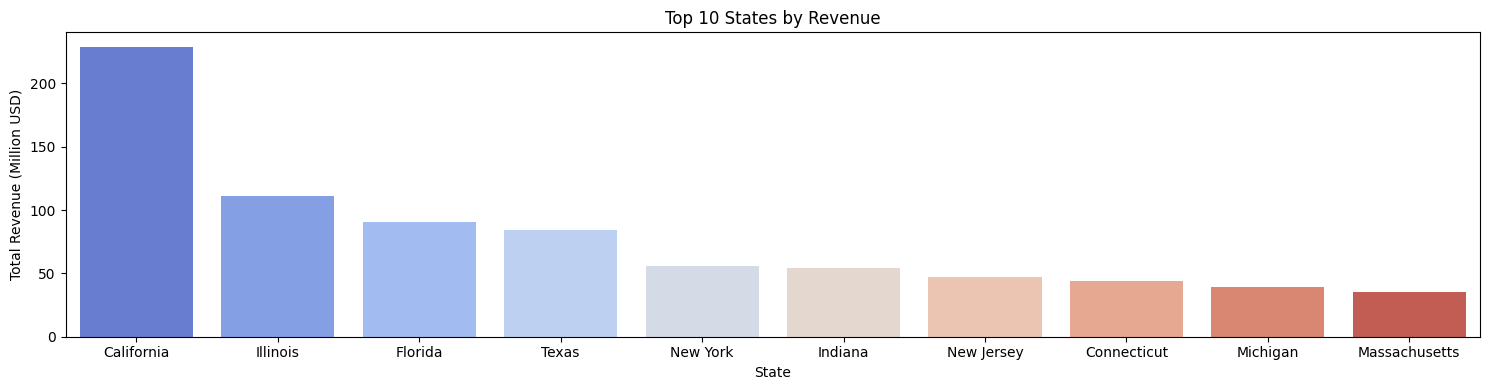

/tmp/ipython-input-75-1617384210.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




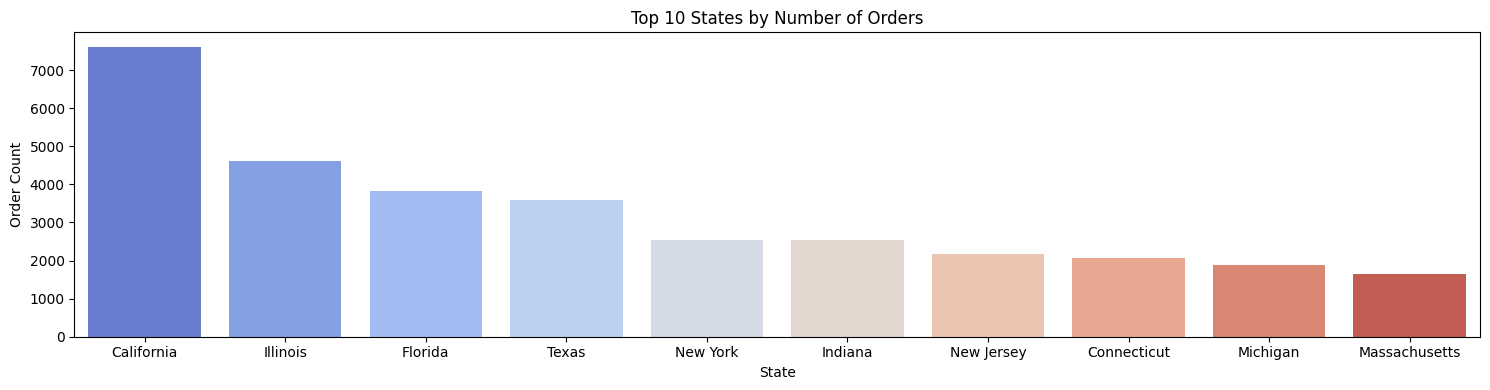

In [75]:
# Aggregate total revenue and unique order count per state
state_rev = df.groupby('state_name').agg(
    revenue=('revenue', 'sum'),          # Sum up revenue per state
    orders=('order_number', 'nunique')   # Count unique orders per state
).sort_values('revenue', ascending=False).head(10)  # Keep top 10 by revenue

# Plot 1: Top 10 states by revenue (scaled to millions)
plt.figure(figsize=(15, 4))
sns.barplot(
    x=state_rev.index,                   # X-axis: state names
    y=state_rev['revenue'] / 1e6,        # Y-axis: revenue in millions
    palette='coolwarm'                   # Color palette
)
plt.title('Top 10 States by Revenue')     # Chart title
plt.xlabel('State')                       # X-axis label
plt.ylabel('Total Revenue (Million USD)') # Y-axis label
plt.tight_layout()                        # Adjust layout
plt.show()                                # Display the plot

# Plot 2: Top 10 states by number of orders
plt.figure(figsize=(15, 4))
sns.barplot(
    x=state_rev.index,                   # X-axis: state names
    y=state_rev['orders'],               # Y-axis: order counts
    palette='coolwarm'                   # Color palette
)
plt.title('Top 10 States by Number of Orders')  # Chart title
plt.xlabel('State')                              # X-axis label
plt.ylabel('Order Count')                        # Y-axis label
plt.tight_layout()                               # Adjust layout
plt.show()

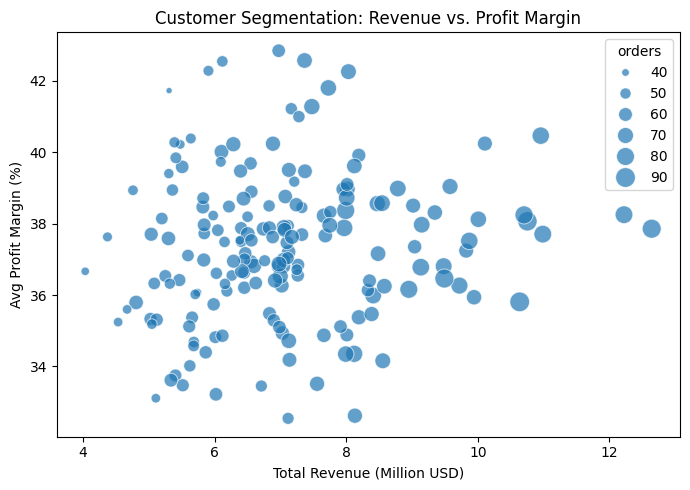

In [76]:

# Aggregate metrics per customer
cust_summary = df.groupby('customer_name').agg(
    total_revenue=('revenue', 'sum'),
    total_profit=('profit', 'sum'),
    avg_margin=('profit_margin_pct', 'mean'),
    orders=('order_number', 'nunique')
)

# Convert revenue to millions
cust_summary['total_revenue_m'] = cust_summary['total_revenue'] / 1e6

plt.figure(figsize=(7, 5))

# Bubble chart with revenue in millions
sns.scatterplot(
    data=cust_summary,
    x='total_revenue_m',        # <-- use revenue in millions
    y='avg_margin',
    size='orders',
    sizes=(20, 200),
    alpha=0.7
)

plt.title('Customer Segmentation: Revenue vs. Profit Margin')
plt.xlabel('Total Revenue (Million USD)')  # <-- updated label
plt.ylabel('Avg Profit Margin (%)')

plt.tight_layout()
plt.show()

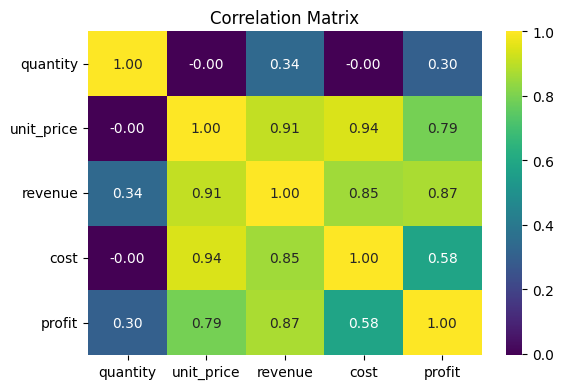

In [77]:
# List numeric columns to include in the correlation calculation
num_cols = ['quantity', 'unit_price', 'revenue', 'cost', 'profit']

# Calculate the correlation matrix for these numeric features
corr = df[num_cols].corr()

# Set the figure size for clarity
plt.figure(figsize=(6,4))

# Plot the heatmap with annotations and a viridis colormap
sns.heatmap(
    corr,           # Data: correlation matrix
    annot=True,     # Display the correlation coefficients on the heatmap
    fmt=".2f",      # Format numbers to two decimal places
    cmap='viridis'  # Color palette for the heatmap
)

# Add title for context
plt.title('Correlation Matrix')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the heatmap
plt.show()

In [78]:
df

,order_number,order_date,customer_name,channel,product_name,quantity,unit_price,revenue,cost,state,...,us_region,lat,lon,budget,total_cost,profit,profit_margin_pct,order_month,order_month_name,order_month_num
0,SO - 000225,2014-01-01,Rhynoodle Ltd,Wholesale,Product 27,6,2499.1,14994.6,1824.343,GA,...,South,32.08354,-81.09983,NaN,10946.058,4048.542,27.0,2014-01,January,1
1,SO - 0003378,2014-01-01,Thoughtmix Ltd,Distributor,Product 20,11,2351.7,25868.7,1269.918,IN,...,Midwest,39.61366,-86.10665,NaN,13969.098,11899.602,46.0,2014-01,January,1
2,SO - 0005126,2014-01-01,Amerisourc Corp,Wholesale,Product 26,6,978.2,5869.2,684.740,CA,...,West,37.66243,-121.87468,NaN,4108.440,1760.760,30.0,2014-01,January,1
3,SO - 0005614,2014-01-01,Colgate-Pa Group,Export,Product 7,7,2338.3,16368.1,1028.852,IN,...,Midwest,39.16533,-86.52639,NaN,7201.964,9166.136,56.0,2014-01,January,1
4,SO - 0005781,2014-01-01,Deseret Group,Wholesale,Product 8,8,2291.4,18331.2,1260.270,CT,...,Northeast,41.77524,-72.52443,NaN,10082.160,8249.040,45.0,2014-01,January,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64099,SO - 0007573,2018-02-28,Dazzlesphe Corp,Wholesale,Product 26,12,1815.7,21788.4,980.478,PA,...,Northeast,40.15511,-74.82877,NaN,11765.736,10022.664,46.0,2018-02,February,2
64100,SO - 0007706,2018-02-28,Yombu Corp,Export,Product 21,6,864.3,5185.8,579.081,IL,...,Midwest,42.11030,-88.03424,NaN,3474.486,1711.314,33.0,2018-02,February,2
64101,SO - 0007718,2018-02-28,Bath Group,Distributor,Product 13,11,3953.0,43483.0,2648.510,FL,...,South,26.24453,-80.20644,NaN,29133.610,14349.390,33.0,2018-02,February,2
64102,SO - 0008084,2018-02-28,Linklinks Ltd,Distributor,Product 20,7,3959.7,27717.9,2930.178,NY,...,Northeast,42.91002,-78.74182,NaN,20511.246,7206.654,26.0,2018-02,February,2


In [79]:

# Export Final DataFrame to CSV
df.to_csv('Sales_data(EDA Exported).csv', index=False)

Key Insights
- Monthly Revenue Cycle:
Revenue stays stable between ≈ 26.5M across 2014–2017, with no consistent seasonal spikes. Sharpest drop (≈$21.2M) occurs in early 2017, indicating a possible one-time disruption.

- Channel Mix:
Wholesale: 54%. Distributors: 31%. Exports: 15% — opportunity to scale international presence.

- Top Products (Revenue):
Product 26:
110M; Product 13:
68–75M; bottom performers: $52–57M.

- Profit Margins:
Profit margins range broadly from ≈18% to ≈60%, with no strong correlation to unit price. Dense horizontal bands suggest standardized pricing strategies across tiers.

- Seasonal Volume:
No strong monthly pattern, but slight volume uptick appears around May–June. Early 2017 dip (≈$21.2M) may require investigation.

- Regional Performance:
California leads: ≈230M Revenue & 7500+ orders. Illinois/Florida/Texas: ≈
85M–110M & ≈3500–4500 orders. NY/Indiana: ≈
54M & 2000+ orders.